<a href="https://colab.research.google.com/github/gundaminpde/2023_F_ML_lecture/blob/main/REINFORCE_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym ## ==0.17.3
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 8 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [3]:
from IPython import display as ipythondisplay

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:

import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

import gym




/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


1/1 [==============================] - 0s 33ms/step


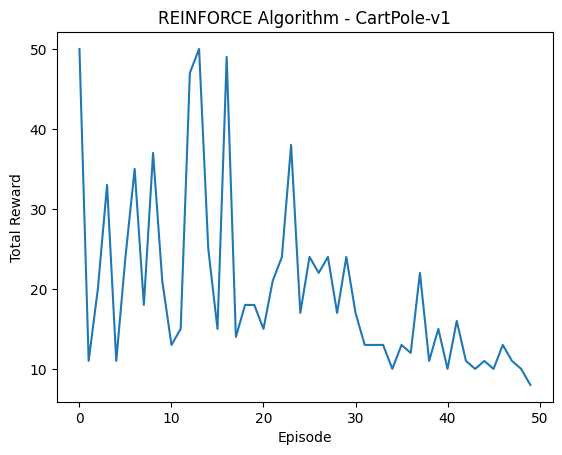

In [5]:

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define the REINFORCE function
def reinforce(env, num_episodes=50, learning_rate=0.01, gamma=0.99): ## 원래는 1000
    # Get the number of actions and observations from the environment
    num_actions = env.action_space.n
    num_observations = env.observation_space.shape[0]

    # Create a simple neural network as the policy function
    model = Sequential()
    model.add(Dense(32, input_shape=(num_observations,), activation='relu'))
    model.add(Dense(num_actions, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate))

    episode_rewards = []

    for episode in range(num_episodes):
        observation = env.reset()
        done = False
        episode_reward = 0

        # Lists to store the trajectory data
        observations = []
        actions = []
        rewards = []

        while not done:
            # Get the action probabilities based on the current observation and policy
            action_probabilities = model.predict(np.expand_dims(observation, axis=0)).flatten()

            # Check for NaN values in action probabilities
            if np.isnan(action_probabilities).any():
                break

            # Sample an action from the action probabilities
            action = np.random.choice(range(num_actions), p=action_probabilities)

            # Take a step in the environment with the chosen action
            new_observation, reward, done, _ = env.step(action)

            # Store the trajectory data
            observations.append(observation)
            actions.append(action)
            rewards.append(reward)

            episode_reward += reward
            observation = new_observation

        if not np.isnan(action_probabilities).any():
            # Convert lists to numpy arrays for easier manipulation
            observations = np.array(observations)
            actions = np.array(actions)
            rewards = np.array(rewards)

            # Calculate the return (discounted cumulative rewards) for each time step
            returns = np.zeros_like(rewards)
            G = 0
            for t in reversed(range(len(rewards))):
                G = rewards[t] + gamma * G
                returns[t] = G

            # Compute the policy gradient update
            for t in range(len(rewards)):
                state = observations[t]
                action = actions[t]
                discounted_return = returns[t]

                # Compute the action probabilities for the current state
                action_probabilities = model.predict(np.expand_dims(state, axis=0)).flatten()

                # Create a one-hot vector for the chosen action
                target = np.zeros(num_actions)
                target[action] = 1

                # Update the policy weights using policy gradient update
                model.train_on_batch(np.expand_dims(state, axis=0), np.expand_dims(discounted_return * target, axis=0))

            episode_rewards.append(episode_reward)

    return episode_rewards


# Main code to run REINFORCE and visualize rewards
if __name__ == "__main__":
    env = gym.make('CartPole-v1')

    # Set random seed for reproducibility (optional)
    np.random.seed(42)

    # Run REINFORCE algorithm
    episode_rewards = reinforce(env, num_episodes=50, learning_rate=0.01, gamma=0.99) ## 원래는 1000

    # Visualize rewards
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE Algorithm - CartPole-v1')
    plt.show()